In [1]:
import torchvision
from tqdm import tqdm
import numpy as np
from torch.utils import data
import matplotlib.pyplot as plt
import flax
import flax.linen as nn
from flax.training import train_state, checkpoints
import optax
import jax
from jax import random
import jax.numpy as jnp
import jax_resnet
from flax.core.frozen_dict import freeze, unfreeze

2022-11-03 11:57:47.693360: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 11:57:48.080952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-03 11:57:48.080995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-03 11:57:48.080999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
np.set_printoptions(suppress = True)

## Data

In [3]:
class TransformsSimCLR:
    """
    A stochastic data augmentation module that transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x i and x j, which we consider as a positive pair.
    """

    def __init__(self, is_pretrain=True, is_val=False):
        self.is_pretrain=is_pretrain
        self.is_val=is_val
        s = 1
        color_jitter = torchvision.transforms.ColorJitter(
            0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
        )
        self.train_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomHorizontalFlip(),  # with 0.5 probability
                torchvision.transforms.RandomApply([color_jitter], p=0.8),
                torchvision.transforms.RandomGrayscale(p=0.2),
                torchvision.transforms.Lambda(np.array),
            ]
        )

        self.test_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Lambda(np.array),
            ]
        )

    def __call__(self, x):
        if self.is_pretrain:
            return self.train_transform(x), self.train_transform(x)
        else:
            if self.is_val:
                return self.test_transform(x)
            else:
                return self.train_transform(x)

In [4]:
pretrain_dataset = torchvision.datasets.CIFAR10(
    './cifar10',
    download=True,
    transform=TransformsSimCLR(is_pretrain=True, is_val=False),
    train=True
)


Files already downloaded and verified


In [5]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

In [6]:
pretrain_dataloader = NumpyLoader(pretrain_dataset, batch_size=128)

Image x1 shape:  (32, 32, 3) 
Image x2 shape:  (32, 32, 3) 
class index y:  9 



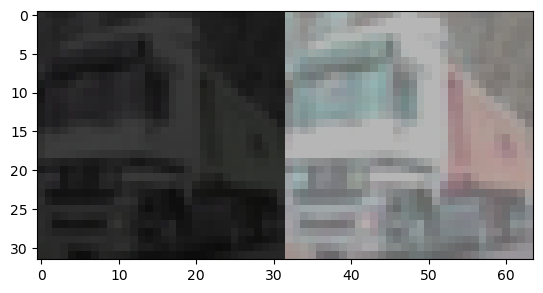

In [7]:
(x1,x2), y = pretrain_dataset[1]
print("Image x1 shape: ", x1.shape, 
      "\nImage x2 shape: ", x2.shape, 
      "\nclass index y: ", y, "\n")

merged_images = np.concatenate([x1,x2], axis=1)
plt.imshow(merged_images)

## Model

In [8]:
key1 = random.PRNGKey(42)

In [9]:
key2, param_key = random.split(key1)

dummy_input = np.zeros((8,32,32,3))

# n_classes doesn't matter, we remove the only layer impacted by it anyway.
# But we need to pass it to construct a ResNet. 
base_model = jax_resnet.ResNet18(n_classes=2)

base_params = base_model.init(rngs=param_key, x=dummy_input)

In [10]:
class EncoderWithProjectionHead(nn.Module):
    encoder : nn.Sequential

    def setup(self):
        self.proj_head = nn.Sequential([
            nn.Dense(features=128), 
            nn.relu, 
            nn.Dense(features=10)
            ])

    def __call__(self, x):
        x = self.encoder(x)
        return self.proj_head(x)

In [11]:
key3, param_key = random.split(key2)

encoder = EncoderWithProjectionHead(encoder=nn.Sequential(base_model.layers[:-1]))
pretrain_params = encoder.init(rngs=param_key, x=dummy_input)

pretrain_params = unfreeze(pretrain_params)
pretrain_params['params']['backbone'] = base_params["params"] 
pretrain_params['batch_stats']['backbone'] = base_params["batch_stats"]
pretrain_params = freeze(pretrain_params)

pretrain_params

FrozenDict({
    batch_stats: {
        encoder: {
            layers_0: {
                ConvBlock_0: {
                    BatchNorm_0: {
                        mean: DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                                     0., 0., 0., 0.], dtype=float32),
                        var: DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                                     1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                                     1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                                     1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
  

## Utils

In [12]:
class TrainState(train_state.TrainState):
    batch_stats: flax.core.FrozenDict

def create_train_state(model, params, config, freeze_encoder=False):
    if freeze_encoder:
        tx = optax.multi_transform({
                'zero': zero_grads(), 
                'sgd': optax.sgd(
                    config["learning_rate"], 
                    config["momentum"],
                )
            },
            freeze({'backbone':'zero', 'head': 'sgd'})
        )
    else:
        tx = optax.sgd(config["learning_rate"], config["momentum"])
    return TrainState.create(
        apply_fn=model.apply,
        params=params["params"],
        tx=tx,
        batch_stats=params['batch_stats']
    )

## Self classifier

In [13]:
t_col = 0.05
t_row = 0.1

@jax.jit
def asymmetric_loss(logits1, logits2):
    N, C = logits1.shape
    p_x2_cond_y = jax.nn.softmax(logits2 / t_col, axis=1)
    p_x2_cond_y_sum = jnp.sum(p_x2_cond_y, axis=1, keepdims=True)
    lhs = p_x2_cond_y / p_x2_cond_y_sum

    p_y_cond_x1 = jax.nn.softmax(logits1 / t_row, axis=0)
    p_y_cond_x1_sum = jnp.sum(p_y_cond_x1, axis=0, keepdims=True)
    rhs = (
        jnp.log(N / C)
        + jnp.log(p_y_cond_x1)
        - jnp.log(p_y_cond_x1_sum)
    )
    loss = -jnp.mean(jnp.sum(lhs * rhs, axis=1))
    return loss

@jax.jit
def apply_model(train_state, X1, X2):
    def loss_fn(params):
        X = jnp.concatenate((X1, X2))
        logits, new_state = train_state.apply_fn(
            {
                'params': params,
                'batch_stats': train_state.batch_stats,
            },
            X,
            mutable=['batch_stats']
        )
        logits1, logits2 = jnp.split(logits, 2)

        # Symmetrized loss 
        loss = 0.5 * (asymmetric_loss(logits1, logits2) + asymmetric_loss(logits2, logits1))
        
        return loss, (new_state['batch_stats'], logits1, logits2)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (batch_stats, logits1, logits2)), grads = grad_fn(train_state.params)

    train_state = train_state.apply_gradients(grads=grads, batch_stats=batch_stats)
    return (train_state, logits1, logits2), loss

In [14]:
def pretrain_epoch(train_state, train_dataloader):
    epoch_loss = []
    
    train_dataloader_tqdm = tqdm(train_dataloader)
    for step, ((X1,X2), Y) in enumerate(train_dataloader_tqdm):
        (train_state, Z1, Z2), loss = apply_model(train_state, X1, X2)
        epoch_loss.append(loss)
        train_dataloader_tqdm.set_postfix({'train_loss': loss.item()})
        
    return train_state, np.mean(epoch_loss)

In [15]:
config = {"learning_rate": 0.01, "momentum": 0.9}
pretrain_dataloader = NumpyLoader(pretrain_dataset, batch_size=256)

pretrain_state = create_train_state(encoder, pretrain_params, config)

CHECKPOINT_DIR = "ckpts"

pretrain_losses = []
for epoch in range(1000):
    pretrain_state, pretrain_loss = pretrain_epoch(pretrain_state, 
                                                     pretrain_dataloader)
    pretrain_losses.append(pretrain_loss)
    checkpoints.save_checkpoint(
        ckpt_dir=CHECKPOINT_DIR,
        target=pretrain_state,
        step=epoch,
    )
    print(f"Epoch {epoch}: pretrain loss {pretrain_loss}")



100%|█████████████████████████████| 196/196 [00:40<00:00,  4.81it/s, train_loss=nan]


InvalidCheckpointError: Trying to save an outdated checkpoint at step: "0" and path: "ckpts/checkpoint_0". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.InvalidCheckpointError)

In [ ]:
(x1, x2), _ = pretrain_dataset[1]
logits = encoder.apply({'params': pretrain_state.params, 
              'batch_stats': pretrain_state.batch_stats}, jnp.array([x1, x2]), mutable=False)

probs = jax.nn.softmax(logits, axis=1)
print(np.array(probs))

In [ ]:
imgs = np.array([pretrain_dataset[i][0][0] for i in range(5000)])

In [ ]:
logits = encoder.apply(
    {'params': pretrain_state.params, 
    'batch_stats': pretrain_state.batch_stats},
    jnp.array(imgs), mutable=False)

probs = jax.nn.softmax(logits, axis=1)
classes = jnp.argmax(probs, axis=1)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for class_idx in range(0,9):
    figure = np.zeros((32 * 3, 32 * 3, 3))
    class_imgs = imgs[classes == class_idx]
    for i in range(3):
        for j in range(3):
            idx = 3 * i + j
            if class_imgs.shape[0] <= idx:
                img = np.zeros((32, 32, 3))
            else:
                img = class_imgs[idx] / 255
            figure[
                i * 32 : (i + 1) * 32,
                j * 32 : (j + 1) * 32, :
            ] = img
    ax = axes[class_idx // 3, class_idx % 3]
    ax.imshow(figure)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)